## Leukocytes Image Classification with <b>MONAI DenseNet121</b> and Lightning AI⚡
![img](https://docs.monai.io/projects/monai-deploy-app-sdk/en/0.2.1/_static/MONAI-logo-color.png)
***
Computer vision project _Leukocytes classification from blood smear images - LCBSI_


@AgataPolejowska

### 🔨 📁 Setup the environment - install and import essential packages


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import plotly" || pip install -q plotly
!python -c "import wandb" || pip install -q wandb
!pip install roboflow --quiet
!pip install -U -q torch
!pip install -U -q torchvision
!python -c "import torchmetrics" || pip install -q torchmetrics
!python -c "import pytorch_lightning" || pip install -q pytorch-lightning

In [8]:
import matplotlib.pyplot as plt
import monai
import numpy as np
import PIL
import plotly.express as px
import pytorch_lightning as pl
import seaborn as sns
import torch
import torchmetrics
import torchvision
from monai.config import print_config
from monai.data import DataLoader
from monai.networks.nets import DenseNet121
from monai.optimizers import LearningRateFinder
from monai.transforms import Compose
from monai.utils import set_determinism
from monai.visualize import CAM, GradCAM
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from roboflow import Roboflow
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

sns.set_style()

print_config()


MONAI version: 1.0.1
Numpy version: 1.23.2
Pytorch version: 2.0.0.dev20221214
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /opt/miniconda3/envs/monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.19.3
Pillow version: 9.3.0
Tensorboard version: 2.11.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.0.dev20221214
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.25.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/inst

### 📣📉📈 Configure W&B for results monitoring
![img](https://raw.githubusercontent.com/wandb/assets/main/wandb-logo-yellow-dots-black-wb.svg)


Weight and Biases is used as a MLOps platform in order to track the experiments results.

In [9]:
import wandb

wandb.login()


True

### 🌱 Ensure results reproducibility by setting the seed for MONAI and Pytorch Lightning

In [10]:
set_determinism(seed=0)
pl.seed_everything(0)


Global seed set to 0


0

### 🔧🔒 Create Pytorch Lightning DataModule - LeukocytesDataModule

This module is created so that all the steps needed to process data are encapsulated and easily reusable.

Within this module the following can be performed:
- setting up the dataset by dowloading it from Roboflow
- getting essential information about the dataset
- visualizing sample images from the dataset
- logging to wandb information about the dataset
- <b>getting dataloaders</b>


The dataset used is created by combining the following datasets:
- RAABINC WBC

_Kouzehkanan, Zahra Mousavi, et al. "A large dataset of white blood cells containing cell locations and types, along with segmented nuclei and cytoplasm." Scientific reports 12.1 (2022): 1-14._
- PBC 

_Acevedo, Andrea; Merino, Anna; Alférez, Santiago; Molina, Ángel; Boldú,
Laura; Rodellar, José (2020), “A dataset for microscopic peripheral blood cell images for development of automatic recognition systems”, Mendeley Data, V1, doi: 10.17632/snkd93bnjr.1_

Data is split to 70% training data, 15% validation data and 15% test data.

5000 images are divided into:

- train data: 3500 images - 700 images per each class (350 for each dataset except basophil class from PBC - 550 images and from RAABIN-WBC - 150 images)
- validation data: 750 images - 150 images per each class (75 for each dataset except basophil class from PBC - 45 images and from RAABIN-WBC - 30 images)
- test data: 750 images - 150 images per each class (75 for each dataset except basophil class from PBC - 45 images and from RAABIN-WBC - 30 images)

In [137]:
class LeukocytesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 10,
        num_classes: int = 5,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_workers = num_workers

    def setup(self):
        rf = Roboflow(api_key="3a7r2eyLT0LA2P5AUyvr")
        workspace = rf.workspace("lcbsiwbc")

        project_train = workspace.project("lcbsi-wbc-train")
        dataset_train = project_train.version(1).download("folder")

        project_valid = workspace.project("lcbsi-wbc-valid")
        dataset_valid = project_valid.version(1).download("folder")

        project_test = workspace.project("lcbsi-wbc")
        dataset_test = project_test.version(1).download("folder")

        self.data_dir = "lcbsi_dataset"
        self.path_to_dataset = Path(self.data_dir)
        os.makedirs(self.data_dir, exist_ok=True)

        def move_folder(src, dst):
            import shutil

            for folder in os.listdir(src):
                new_path = os.path.join(dst, folder)
                if os.path.exists(new_path):
                    if os.path.isdir(new_path):
                        shutil.rmtree(new_path)
                    else:
                        os.remove(new_path)
                os.rename(os.path.join(src, folder), new_path)

        move_folder(dataset_train.location, self.data_dir)
        move_folder(dataset_valid.location, self.data_dir)
        move_folder(dataset_test.location, self.data_dir)

        print(f"Dataset downloaded to {self.data_dir}")
        print(f"Path to dataset: {self.path_to_dataset}")

    def train_dataset(self, dataset_transforms):
        self.train_dataset = ImageFolder(
            self.path_to_dataset / "train", dataset_transforms
        )
        return self.train_dataset

    def val_dataset(self, dataset_transforms):
        self.val_dataset = ImageFolder(
            self.path_to_dataset / "valid", dataset_transforms
        )
        return self.val_dataset

    def test_dataset(self, dataset_transforms):
        self.test_dataset = ImageFolder(
            self.path_to_dataset / "test", dataset_transforms
        )
        return self.test_dataset

    def train_dataloader(self, batch_size=32, num_workers=10):
        return DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
        )

    def val_dataloader(self, batch_size=32, num_workers=10):
        return DataLoader(
            self.val_dataset, batch_size=batch_size, num_workers=num_workers
        )

    def test_dataloader(self, batch_size=32, num_workers=10):
        return DataLoader(
            self.test_dataset, batch_size=batch_size, num_workers=num_workers
        )

    def visualize_dataset(self, wandb_log=False):
        train_files = []
        for name in self.class_names:
            train_files.extend(
                [
                    os.path.join(self.data_dir, "train", name, x)
                    for x in os.listdir(os.path.join(self.data_dir, "train", name))
                ]
            )
        print(f"Number of train files: {len(train_files)}")

        with PIL.Image.open(train_files[0]) as img:
            img_size = img.size
        print(f"Image size: {img_size}")

        train_files = np.random.choice(train_files, 9, replace=False)
        _, axes = plt.subplots(3, 3, figsize=(12, 12))
        for i, file in enumerate(train_files):
            with PIL.Image.open(file) as img:
                ax = axes[i // 3, i % 3]
                ax.set_title(os.path.basename(os.path.dirname(file)))
                ax.imshow(img)
                ax.axis("off")
                if wandb_log:
                    wandb.log({f"train example image {i}": wandb.Image(img)})
        plt.tight_layout()
        plt.show()

    def get_classes_info(self):
        self.class_names = sorted(
            [
                name
                for name in os.listdir(os.path.join(self.data_dir, "train"))
                if os.path.isdir(os.path.join(self.data_dir, "train", name))
            ]
        )
        num_classes = len(self.class_names)
        print(f"Class names: {self.class_names} ({num_classes} classes)")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-WBC-TRAIN-1 in folder:: 100%|██████████| 3508/3508 [00:00<00:00, 11771.02it/s]

loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-WBC-VALID-1 in folder:: 100%|██████████| 758/758 [00:00<00:00, 12239.40it/s]

loading Roboflow project...


Extracting Dataset Version Zip to LCBSI-WBC-1 in folder:: 100%|██████████| 758/758 [00:00<00:00, 11969.24it/s]

Dataset downloaded to lcbsi_dataset
Path to dataset: lcbsi_dataset
Class names: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'] (5 classes)
Number of train files: 3500
Image size: (256, 256)


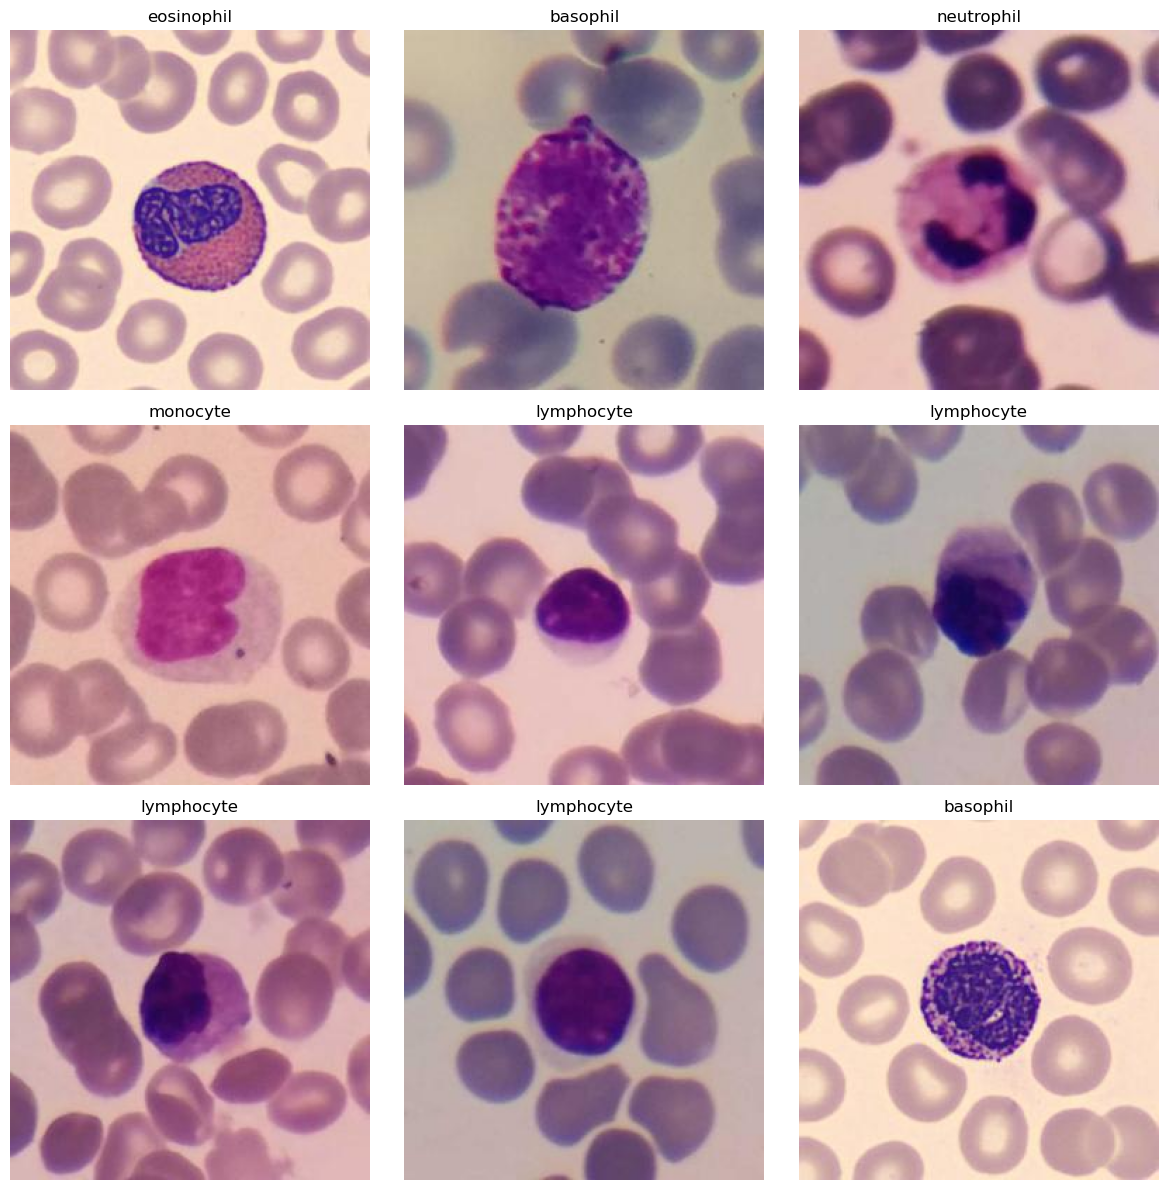

In [12]:
NUM_CLASSES = 5
BATCH_SIZE = 32

leukocytes_data_module = LeukocytesDataModule(
    batch_size=BATCH_SIZE, num_classes=NUM_CLASSES
)
leukocytes_data_module.setup()

leukocytes_data_module.get_classes_info()
leukocytes_data_module.visualize_dataset()

In [165]:
leukocytes_data_module.class_names

['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

#### W&B setup

In [13]:
PROJECT = "lcbsi-densenet-monai-ap"
ENTITY = "polejowska"

#### W&B dataset upload as an Artifact

In [ ]:
run = wandb.init(project=PROJECT, entity=ENTITY, job_type="upload")

raw_data_artifact = wandb.Artifact("raw_data", type="dataset")
raw_data_artifact.add_dir(leukocytes_data_module.data_dir)

run.log_artifact(raw_data_artifact)

run.finish()


#### W&B dataset download to track the lineage of models

In [ ]:
run = wandb.init(project=PROJECT, entity=ENTITY)

artifact = run.use_artifact(f"{ENTITY}/{PROJECT}/raw_data:v0", type="dataset")

artifact_dir = artifact.download()


In [ ]:
leukocytes_data_module.data_dir = artifact_dir
leukocytes_data_module.path_to_dataset = Path(artifact_dir)
leukocytes_data_module.path_to_dataset


#### Transform dataset for training
#### Create dataloaders

In [14]:
IMG_SIZE_RESIZE = (128, 128)

TRANSFORMS = Compose(
    [
        transforms.Resize(IMG_SIZE_RESIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = leukocytes_data_module.train_dataset(dataset_transforms=TRANSFORMS)
validation_dataset = leukocytes_data_module.val_dataset(dataset_transforms=TRANSFORMS)
test_dataset = leukocytes_data_module.test_dataset(dataset_transforms=TRANSFORMS)


In [15]:
train_dataset


Dataset ImageFolder
    Number of datapoints: 3500
    Root location: lcbsi_dataset/train
    StandardTransform
Transform: <monai.transforms.compose.Compose object at 0x2a0d29f10>

In [16]:
validation_dataset


Dataset ImageFolder
    Number of datapoints: 750
    Root location: lcbsi_dataset/valid
    StandardTransform
Transform: <monai.transforms.compose.Compose object at 0x2a0d29f10>

In [17]:
test_dataset


Dataset ImageFolder
    Number of datapoints: 750
    Root location: lcbsi_dataset/test
    StandardTransform
Transform: <monai.transforms.compose.Compose object at 0x2a0d29f10>

In [139]:
train_dataloader = leukocytes_data_module.train_dataloader()
val_dataloader = leukocytes_data_module.val_dataloader()
test_dataloader = leukocytes_data_module.test_dataloader()

### 🔧🎺 Create Pytorch Lightning Module - Model

This class organizes the code into the most important sections: computations, train loop, validation loop, test loop, prediction loop, optimizers.<br>

In [188]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

        self.classes = leukocytes_data_module.class_names

        self.train_acc = torchmetrics.classification.MulticlassAccuracy(num_classes=5)
        self.val_acc = torchmetrics.classification.MulticlassAccuracy(num_classes=5)
        self.test_acc = torchmetrics.classification.MulticlassAccuracy(num_classes=5)
        
        self.train_f1 = torchmetrics.classification.MulticlassF1Score(num_classes=5)
        self.val_f1 = torchmetrics.classification.MulticlassF1Score(num_classes=5)
        self.test_f1 = torchmetrics.classification.MulticlassF1Score(num_classes=5)
        
        self.train_precision = torchmetrics.classification.MulticlassPrecision(num_classes=5)
        self.val_precision = torchmetrics.classification.MulticlassPrecision(num_classes=5)
        self.test_precision = torchmetrics.classification.MulticlassPrecision(num_classes=5)

        self.train_recall = torchmetrics.classification.MulticlassRecall(num_classes=5)
        self.val_recall = torchmetrics.classification.MulticlassRecall(num_classes=5)
        self.test_recall = torchmetrics.classification.MulticlassRecall(num_classes=5)

        self.train_specificity = torchmetrics.classification.MulticlassSpecificity(num_classes=5)
        self.val_specificity = torchmetrics.classification.MulticlassSpecificity(num_classes=5)
        self.test_specificity = torchmetrics.classification.MulticlassSpecificity(num_classes=5)

        self.confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=5)
        self.pr_curve = torchmetrics.classification.MulticlassPrecisionRecallCurve(num_classes=5)

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        x, y = batch
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return x.to(device), y.to(device)

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)

        acc = self.train_acc(y_hat, y)
        f1 = self.train_f1(y_hat, y)
        precision = self.train_precision(y_hat, y)
        recall = self.train_recall(y_hat, y)
        specificity = self.train_specificity(y_hat, y)

        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True)
        self.log("train_f1", f1, on_step=True, on_epoch=True, logger=True)
        self.log("train_precision", precision, on_step=True, on_epoch=True, logger=True)
        self.log("train_recall", recall, on_step=True, on_epoch=True, logger=True)
        self.log("train_specificity", specificity, on_step=True, on_epoch=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)

        acc = self.val_acc(y_hat, y)
        f1 = self.val_f1(y_hat, y)
        precision = self.val_precision(y_hat, y)
        recall = self.val_recall(y_hat, y)
        specificity = self.val_specificity(y_hat, y)

        self.log("val_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, logger=True)
        self.log("val_f1", f1, on_step=True, on_epoch=True, logger=True)
        self.log("val_precision", precision, on_step=True, on_epoch=True, logger=True)
        self.log("val_recall", recall, on_step=True, on_epoch=True, logger=True)
        self.log("val_specificity", specificity, on_step=True, on_epoch=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)

        acc = self.test_acc(y_hat, y)
        f1 = self.test_f1(y_hat, y)
        precision = self.test_precision(y_hat, y)
        recall = self.test_recall(y_hat, y)
        specificity = self.test_specificity(y_hat, y)


        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_acc", acc, prog_bar=True, logger=True)
        self.log("test_f1", f1, prog_bar=True, logger=True)
        self.log("test_precision", precision, prog_bar=True, logger=True)
        self.log("test_recall", recall, prog_bar=True, logger=True)
        self.log("test_specificity", specificity, prog_bar=True, logger=True)

        return loss

### 🔩📏 Configure the model

1. Model DenseNet121 is initialized using MONAI framework.
2. Pretrained model from _https://github.com/Project-MONAI/model-zoo/releases/tag/hosting_storage_v1_ (_https://github.com/Project-MONAI/model-zoo/tree/dev/models/pathology_nuclei_classification_) is downloaded.
3. First layer and last layers of the pretrained model is adjusted to the corresponding layers in created DenseNet121 model to avoid size mismatch errors regarding input channels number and output channels.
4. Parameters and buffers are copied from pretrained model to created DenseNet121.
5. All layers from denseblock1 to denseblock2 inclusive are frozen so that they won't be trained. The rest of the layers are trained ensuring the model learns to classify leukocytes.

In [189]:
IN_CHANNELS = 3
SPATIAL_DIMS = 2
PRETRAINED = False

model_DenseNet121 = DenseNet121(
    pretrained=PRETRAINED,
    in_channels=IN_CHANNELS,
    out_channels=NUM_CLASSES,
    spatial_dims=SPATIAL_DIMS,
)


In [190]:
pretrained_model = monai.bundle.load(
    name="pathology_nuclei_classification", bundle_dir="./", version="0.0.1"
)

pretrained_model["features.conv0.weight"] = model_DenseNet121.features.conv0.weight
pretrained_model["class_layers.out.weight"] = model_DenseNet121.class_layers.out.weight
pretrained_model["class_layers.out.bias"] = model_DenseNet121.class_layers.out.bias

model_DenseNet121.load_state_dict(pretrained_model)


<All keys matched successfully>

In [191]:
for param in model_DenseNet121.features.denseblock1.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition1.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.denseblock2.parameters():
    param.requires_grad = False

for param in model_DenseNet121.features.transition2.parameters():
    param.requires_grad = False


In [192]:
for param in model_DenseNet121.features.denseblock3.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.transition3.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.denseblock4.parameters():
    param.requires_grad = True

for param in model_DenseNet121.features.norm5.parameters():
    param.requires_grad = True

for param in model_DenseNet121.class_layers.parameters():
    param.requires_grad = True


### 🔧 Create the Pytorch Lightning Model ⚡ with pretrained model from MONAI 🌐


### 🚅💪 Train the model using Pytorch Lightning ⚡

#### 🕵️ W&B sweep configuration

In [193]:
sweep_config = {"method": "bayes"}

metric = {"name": "val_loss", "goal": "minimize"}

sweep_config["metric"] = metric

# hyperparameters

hyperparameters_dict = {
    "learning_rate": {"distribution": "uniform", "min": 0, "max": 0.1},
    "batch_size": {"values": [8, 16, 32, 64, 128]},
    "optimizer": {"values": ["Adam", "SGD", "AdamW"]},
    "epochs": {"value": 2},
}

sweep_config["parameters"] = hyperparameters_dict

import pprint

pprint.pprint(sweep_config)


{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [8, 16, 32, 64, 128]},
                'epochs': {'value': 2},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['Adam', 'SGD', 'AdamW']}}}


In [174]:
sweep_id = wandb.sweep(sweep_config, entity=ENTITY, project=PROJECT)

Create sweep with ID: f4h0dqno
Sweep URL: https://wandb.ai/polejowska/lcbsi-densenet-monai-ap/sweeps/f4h0dqno


#### W&B configuration for training monitoring

In [184]:
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples


early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min"
)

checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max")

CALLBACKS = [ImagePredictionLogger(next(iter(test_dataloader))), checkpoint_callback]
LOG_EVERY_N_STEPS = 25
CRITERION = torch.nn.CrossEntropyLoss()


In [194]:
def get_optimizer_class(optimizer_name):
    if optimizer_name == "Adam":
        return torch.optim.Adam
    elif optimizer_name == "SGD":
        return torch.optim.SGD
    elif optimizer_name == "AdamW":
        return torch.optim.AdamW
    else:
        raise ValueError(f"Optimizer {optimizer_name} is not supported")


In [195]:
import time

def sweep(config=None):

    with wandb.init(config=config) as run:
        config = run.config

        logger = pl.loggers.WandbLogger(experiment=run, log_model=True)

        gpus = -1 if torch.cuda.is_available() else 0

        trainer = pl.Trainer(
            #accelerator='mps', devices=1,
            gpus=gpus,
            max_epochs=config.epochs,
            logger=logger,
            callbacks=CALLBACKS,
            log_every_n_steps=LOG_EVERY_N_STEPS,
            enable_progress_bar=True,
            enable_model_summary=True,
        )

        optimizer_class = get_optimizer_class(config.optimizer)

        model = Model(
            model_DenseNet121, CRITERION, config.learning_rate, optimizer_class
        )
        train_data_loader = DataLoader(
            train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=10
        )
        val_data_loader = DataLoader(
            validation_dataset, batch_size=config.batch_size, shuffle=False, num_workers=10
        )
        test_data_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=10
        )

        start_time = time.time()
        trainer.fit(model, train_data_loader, val_data_loader)
        end_time = time.time()
        time_taken_minutes = (end_time - start_time) / 60
        print(f"Training time: {time_taken_minutes:.2f} minutes")
        run.summary["training_time"] = time_taken_minutes
        trainer.validate(model, val_data_loader)
        trainer.test(model, test_data_loader)

        # torch.save(model.state_dict(), f"model_{run.name}.pt")
        # model_artifact = wandb.Artifact(
        #     f"model_{run.name}",
        #     type="model",
        #     description="Model generated using a sweep",
        # )
        # model_artifact.add_file(f"model_{run.name}.pt")
        # run.log_artifact(model_artifact)


In [196]:
wandb.agent(sweep_id, sweep, count=1)

wandb: Agent Starting Run: 8au83811 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 2
wandb: 	learning_rate: 0.09570544464070645
wandb: 	optimizer: AdamW


Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
Checkpoint directory ./lightning_logs/19s4mqb7/checkpoints exists and is not empty.

   | Name              | Type                           | Params
----------------------------------------------------------------------
0  | net               | DenseNet121                    | 7.0 M 
1  | criterion         | CrossEntropyLoss               | 0     
2  | train_acc         | MulticlassAccuracy             | 0     
3  | val_ac

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]